In [8]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import os
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
# Cargo y visualizo los datos de imágenes de perros y gatos
train_dir = r"../data/dogs-vs-cats (1)/dogs-vs-cats/train"

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size=32,
    class_mode="binary",
    subset="training"
)

val_gen = datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size=32,
    class_mode="binary",
    subset="validation"
)


Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


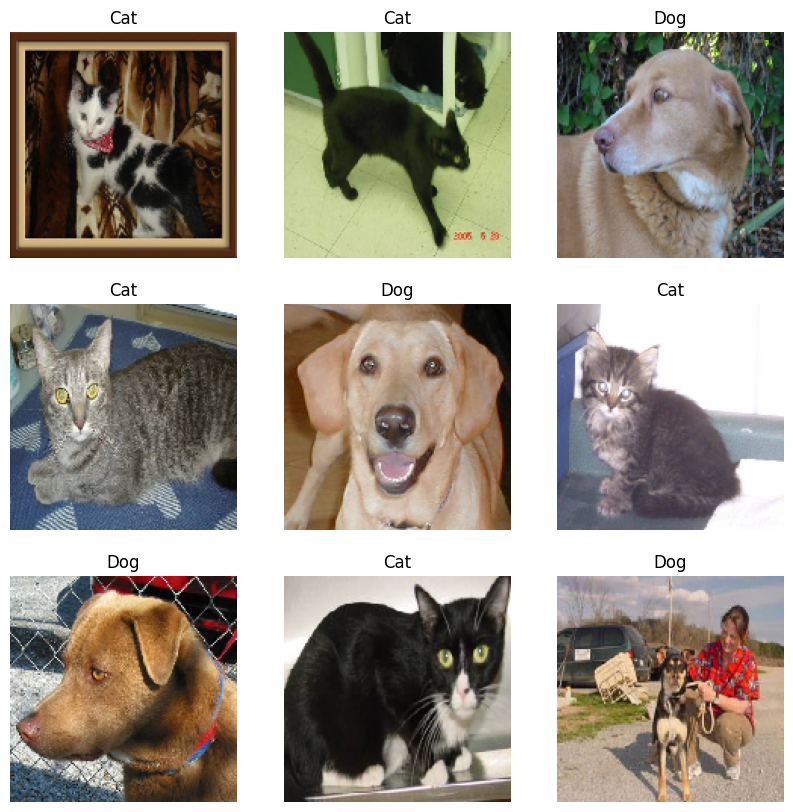

In [5]:
# Visualizo algunas imágenes de entrenamiento
import matplotlib.pyplot as plt
import numpy as np

images, labels = next(train_gen)

plt.figure(figsize=(10, 10))

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i])
    plt.title("Cat" if labels[i] == 0 else "Dog")
    plt.axis("off")

plt.show()


In [7]:
# Defino y compilo el modelo de red neuronal convolucional
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation="relu", input_shape=(150, 150, 3)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation="relu"),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(512, activation="relu"),
    layers.Dense(1, activation="sigmoid")  # salida binaria: perro/gato
])

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()


c:\Users\anto-\miniconda3\envs\dogs-cats\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Configuro callbacks para guardar el mejor modelo y detener el entrenamiento temprano
models_dir = "../models"
os.makedirs(models_dir, exist_ok=True)

checkpoint_cb = ModelCheckpoint(
    filepath=os.path.join(models_dir, "dogs_vs_cats_best.keras"),
    save_best_only=True,
    monitor="val_loss",
    mode="min",
    verbose=1
)

earlystop_cb = EarlyStopping(
    monitor="val_loss",
    patience=3,              # nº de epochs sin mejorar antes de parar
    restore_best_weights=True,
    verbose=1
)


In [10]:
epochs = 20  

history = model.fit(
    train_gen,
    epochs=epochs,
    validation_data=val_gen,
    callbacks=[checkpoint_cb, earlystop_cb]
)


Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.5981 - loss: 0.6667
Epoch 1: val_loss improved from None to 0.53603, saving model to ../models\dogs_vs_cats_best.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 227s 359ms/step - accuracy: 0.6591 - loss: 0.6073 - val_accuracy: 0.7266 - val_loss: 0.5360
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.7628 - loss: 0.4865
Epoch 2: val_loss improved from 0.53603 to 0.43238, saving model to ../models\dogs_vs_cats_best.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 227s 364ms/step - accuracy: 0.7759 - loss: 0.4673 - val_accuracy: 0.8018 - val_loss: 0.4324
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.8163 - loss: 0.3955
Epoch 3: val_loss improved from 0.43238 to 0.39597, saving model to ../models\dogs_vs_cats_best.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 240s 384ms/step - accuracy: 0.8209 - loss: 0.3892 - val_accuracy: 0.8246 - val_loss: 0.3960
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.87

In [ ]:
# Evaluación del modelo en el conjunto de validación, dejando el mejor modelo guardado
val_loss, val_acc = model.evaluate(val_gen)
print(f"Validación - Loss: {val_loss:.4f}  |  Accuracy: {val_acc:.4f}")


157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 85ms/step - accuracy: 0.8304 - loss: 0.3900
Validación - Loss: 0.3900  |  Accuracy: 0.8304


el earlystop funcionó correctamente. A continuación guardamos el modelo

In [12]:
models_dir = "../models"
os.makedirs(models_dir, exist_ok=True)

best_model_path = os.path.join(models_dir, "dogs_vs_cats_best.keras")
final_model_path = os.path.join(models_dir, "dogs_vs_cats_final.keras")

# por si quieres guardar el estado actual del modelo también
model.save(final_model_path)

print("Mejor modelo guardado en:", best_model_path)
print("Modelo final guardado en:", final_model_path)

Mejor modelo guardado en: ../models\dogs_vs_cats_best.keras
Modelo final guardado en: ../models\dogs_vs_cats_final.keras
